In [1]:
import os
import gc
import cv2
import time
import timm
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import albumentations
from pylab import rcParams
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
from torch.utils.data import  Dataset
import torch.nn.functional as F

%matplotlib inline
rcParams['figure.figsize'] = 20, 8
device = torch.device('cuda')
torch.backends.cudnn.benchmark = True

# Config

In [2]:

n_folds = 5
feature_size = 1280

n_slice_per_c = 128 # all abdomen
lstm_size=512


init_lr = 5.0e-4

eta_min = 0
batch_size = 64
drop_rate = 0.
drop_rate_last = 0.3 #  0.1
drop_path_rate = 0.3
p_mixup = 0.3 #0 0.3
p_rand_order_v1 = 0.2

data_dir_bowel = './features2b'
data_dir_lsk = './features2lstm_feat1/'
use_amp = True
num_workers = 6
out_dim = 2

n_epochs = 25

log_dir = './logs'
model_dir = './models_stage3_all'
os.makedirs(log_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

# DataFrame

In [3]:
from sklearn.model_selection import KFold

organ_dict = {
    0: 'bowel',
    1: 'extravasation',
}

df_p = pd.read_csv('/kaggle/input/rsna-2023-abdominal-trauma-detection/train.csv')
df_s=pd.read_csv('/kaggle/input/rsna-2023-abdominal-trauma-detection/train_series_meta.csv')

df_p['fold'] = -1
kf = KFold(5,shuffle=True,random_state=42)
for fold, (train_idx, valid_idx) in enumerate(kf.split(df_p,df_p)):
    df_p.loc[valid_idx, 'fold'] = fold



df=df_p.merge(df_s,on="patient_id")
df["count"]=df.groupby(["patient_id"])["patient_id"].transform("count")


pid=[]
sid = []
cs = []
label = []
fold = []
hu=[]
counts=[]
lbowel=[]
lextra=[]
for row in df.to_dict(orient="records"):
        pid.append(row["patient_id"])
        sid.append(row["series_id"])
        hu.append(row["aortic_hu"])
        la=[row["bowel_injury"],row["extravasation_injury"]]
        label.append(la)
        lbowel.append(la[0])
        lextra.append(la[1])
        fold.append(row["fold"])
        counts.append(row["count"])

df = pd.DataFrame({
    'patient_id': pid,
    'series_id': sid,
    'hu':hu,
    'label': label,
    'bowel':lbowel,
    "extravasation":lextra,
    'fold': fold,
    'counts':counts,
})
df.set_index(['patient_id', 'series_id'], inplace=True,drop=False)
df.index.names=["pid","sid"]
df.sort_values(by=["patient_id","hu"],inplace=True)



In [4]:

df


patient_id  series_id      hu   label  bowel  extravasation  \
pid   sid                                                                  
19    14374          19      14374  174.00  [0, 0]      0              0   
26    41997          26      41997  101.00  [0, 0]      0              0   
      18881          26      18881  255.00  [0, 0]      0              0   
33    55570          33      55570  105.00  [1, 1]      1              1   
43    36714          43      36714   54.75  [1, 1]      1              1   
...                 ...        ...     ...     ...    ...            ...   
65456 40781       65456      40781  162.00  [1, 0]      1              0   
65495 8371        65495       8371  248.00  [0, 0]      0              0   
65504 55928       65504      55928  144.00  [0, 0]      0              0   
      50212       65504      50212  276.00  [0, 0]      0              0   
65508 34551       65508      34551  153.00  [0, 0]      0              0   

             fold  counts  
pid   sid                  
19    14374     3       1  
26    41997     2       2  
      18881     2       2  
33    55570     1       1  
43    36714     1       2  
...           ...     ...  
65456 40781     2       1  
65495 8371      1       1  
65504 55928     2       2  
      50212     2       2  
65508 34551     0       1  

[4711 rows x 8 columns]

# Dataset

In [5]:
class CLS3Dataset(Dataset):
    def __init__(self, df, mode, fold):

        self.df = df.reset_index()
        self.mode = mode
        self.fold=fold

    def __len__(self):
        return self.df.patient_id.nunique()

    def __getitem__(self, index):
        rows= df.loc[[df.index.get_level_values(0)[index]]]
        
        data=[]
        for i in range(len(rows)):
            row=rows.iloc[i]
            filepath=os.path.join(data_dir, f'model{self.fold}/{row.patient_id}_{row.series_id}.npy')
            data.append(np.load(filepath))
        if len(rows)==1:
            data.append(np.zeros((n_slice_per_c,feature_size)))
        data=np.concatenate(data,axis=0)

        if self.mode != 'test':
            data = torch.tensor(data).float()
            labels= row.label
            labels = torch.tensor(labels).float()
            counts=torch.tensor(row.counts).float()
            
            if self.mode == 'train' and random.random() < p_rand_order_v1:
                indices1 = torch.randperm(n_slice_per_c)
                indices2 = torch.randperm(n_slice_per_c)+n_slice_per_c
                indices=torch.concat((indices1,indices2))
                data = data[indices]

            return data, labels,counts
        else:
            return torch.tensor(data).float()

In [6]:
rcParams['figure.figsize'] = 20,8

df_show = df
dataset_show = CLS3Dataset(df_show, 'train', fold=0)
print(len(df),len(dataset_show))
loader_show = torch.utils.data.DataLoader(dataset_show, batch_size=batch_size, shuffle=True, num_workers=num_workers)

4711 3147


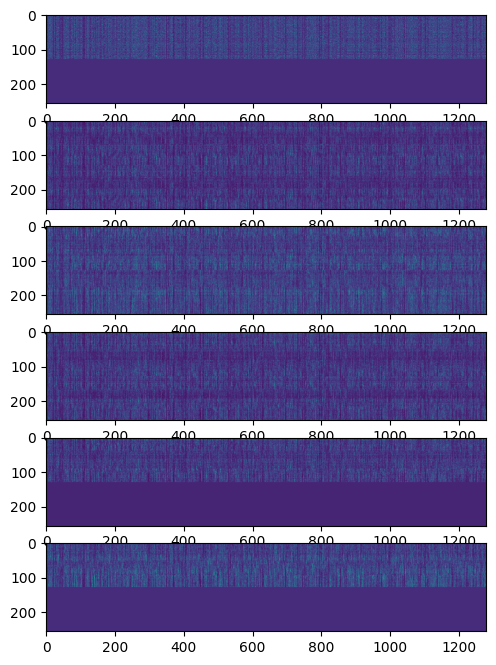

In [7]:
f, axarr = plt.subplots(6)
for p in range(6):
    idx = p * 20
    data, lbl,_ = dataset_show[idx]
    axarr[p].imshow(data)

# Attention

In [8]:
class Attention(nn.Module):
    def __init__(self, feature_dim, step_dim, bias=True, **kwargs):
        super(Attention, self).__init__(**kwargs)
        
        self.supports_masking = True

        self.bias = bias
        self.feature_dim = feature_dim
        self.step_dim = step_dim
        self.features_dim = 0
        
        weight = torch.zeros(feature_dim, 1)
        nn.init.xavier_uniform_(weight)
        self.weight = nn.Parameter(weight)
        
        if bias:
            self.b = nn.Parameter(torch.zeros(step_dim))
        
    def forward(self, x, mask=None):
        feature_dim = self.feature_dim
        step_dim = self.step_dim
        eij = torch.mm(
            x.contiguous().view(-1, feature_dim), 
            self.weight
        ).view(-1, step_dim)
        
        if self.bias:
            eij = eij + self.b
            
        eij = torch.tanh(eij)
        a = torch.exp(eij)
        
        if mask is not None:
            a = a * mask

        a = a / torch.sum(a, 1, keepdim=True) + 1e-10

        weighted_input = x * torch.unsqueeze(a, -1)
        return torch.sum(weighted_input, 1)


In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()
    def reset(self):
        self.avg = 0
        self.sum = 0
        self.weight = 0
        self.count=0
    def update(self, vals, w=1):
        self.val = vals
        self.count += len(vals)
        self.sum += np.sum(vals * w)
        self.weight += np.sum(w)
        self.avg = self.sum / self.weight

In [10]:
class SpatialDropout(nn.Dropout2d):
    def forward(self, x):
        x = x.unsqueeze(2)    # (N, T, 1, K)
        x = x.permute(0, 3, 2, 1)  # (N, K, 1, T)
        x = super(SpatialDropout, self).forward(x)  # (N, K, 1, T), some features are masked
        x = x.permute(0, 3, 2, 1)  # (N, T, 1, K)
        x = x.squeeze(2)  # (N, T, K)
        return x

# Model

In [11]:
class PENet(nn.Module):
    def __init__(self, input_len,lstm_size):
        super().__init__()
        self.input_len=input_len
        self.lstm_size=lstm_size
        self.lstm1 = nn.GRU(input_len, lstm_size, bidirectional=True, batch_first=True)
        self.last_linear_bowel = nn.Linear(lstm_size*4, 1)
        self.last_linear_extravasation = nn.Linear(lstm_size*4, 1)
        self.attention = Attention(lstm_size*2, n_slice_per_c*2)


    def forward(self, x,mask=None):  # (bs, nslice, ch)
        #x = SpatialDropout(0.5)(x)
        #print(x.shape,self.input_len,self.lstm_size)
        h_lstm1, _ = self.lstm1(x)
        #avg_pool = torch.mean(h_lstm2, 1)
        max_pool, _ = torch.max(h_lstm1, 1)
        att_pool = self.attention(h_lstm1, mask)
        conc = torch.cat((max_pool, att_pool), 1)  
        logits_bowel = self.last_linear_bowel(conc)
        logits_extravasation = self.last_linear_extravasation(conc)
        logits_bowel=logits_bowel.squeeze()
        logits_extravasation=logits_extravasation.squeeze()
        return logits_bowel,logits_extravasation 

In [12]:
from torchinfo import summary
model = PENet(input_len=feature_size, lstm_size=lstm_size)
model = model.cuda()
mask = np.zeros((n_slice_per_c,), dtype=np.float32)
print(summary(model,input_size=(batch_size,2*n_slice_per_c,feature_size)))


Layer (type:depth-idx)                   Output Shape              Param #
PENet                                    [64]                      --
├─GRU: 1-1                               [64, 256, 1024]           5,511,168
├─Attention: 1-2                         [64, 1024]                1,280
├─Linear: 1-3                            [64, 1]                   2,049
├─Linear: 1-4                            [64, 1]                   2,049
Total params: 5,516,546
Trainable params: 5,516,546
Non-trainable params: 0
Total mult-adds (G): 90.30
Input size (MB): 83.89
Forward/backward pass size (MB): 134.74
Params size (MB): 22.07
Estimated Total Size (MB): 240.70


In [13]:
criterion = nn.BCEWithLogitsLoss(reduction='none').cuda()

In [14]:
from torch.distributions.beta import Beta
beta=Beta(torch.tensor([0.2]),torch.tensor([0.2]))

def mix_up(x1,y1):
    # Unpack two datasets
    batch_size = x1.shape[0]
    # Sample lambda and reshape it to do the mixup
    l = beta.sample(torch.Size([batch_size])).cuda()
    x_l = l.reshape((batch_size, 1,1))
    y_l = l.reshape((batch_size, 1))
    idx = torch.randperm(batch_size).cuda()
    x2=x1[idx,...]
    y2=y1[idx,...]
    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = x1 * x_l + x2 * (1 - x_l)
    labels = y1 * y_l + y2 * (1 - y_l)
    return (images, labels)


def train_func(model, loader_train, optimizer, scaler,train_bowel_weight,train_extravasation_weight,wbowel=2,wextra=6):
    model.train()
    train_loss = []
    bar = tqdm(loader_train)
    for images, targets,_ in bar:
        optimizer.zero_grad()
        images = images.cuda()
        targets = targets.cuda()
  
        if random.random() < p_mixup:
            images, targets = mix_up(images, targets)

     
        with amp.autocast():
            logits_bowel,logits_extravasation = model(images)
          
            loss_bowel = criterion(logits_bowel, targets[:,0])
            loss_extravasation=criterion(logits_extravasation,targets[:,1])
            weights_bowel=1+targets[:,0]*(wbowel-1)
            weight_extravasation=1+targets[:,1]*(wextra-1)
            loss_bowel= torch.mean(loss_bowel*weights_bowel)/train_bowel_weight
            loss_extravasation=torch.mean(loss_extravasation*weight_extravasation)/train_extravasation_weight

        loss=(loss_bowel+loss_extravasation)/2
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss.append(loss.item())
            
        bar.set_description(f'smth:{np.mean(train_loss[-100:]):.4f}')

    return np.mean(train_loss)


def valid_func(model, loader_valid):
    model.eval()
    valid_loss_bowel=AverageMeter()
    valid_loss_extravasation=AverageMeter()
    bar = tqdm(loader_valid)
    with torch.no_grad():
        for images, targets,counts in bar:
            images = images.cuda()
            targets = targets.cuda()
            counts=counts.cuda()

            with amp.autocast():
                logits_bowel,logits_extravasation = model(images)
                loss_bowel = criterion(logits_bowel, targets[:,0])
                loss_extravasation=criterion(logits_extravasation,targets[:,1])
                weights_bowel=1+targets[:,0]
                weight_extravasation=1+targets[:,1]*5
   
            #print(targets,weights_bowel,weight_extravasation)
            valid_loss_bowel.update(loss_bowel.numpy(force=True),weights_bowel.numpy(force=True))

            valid_loss_extravasation.update(loss_extravasation.numpy(force=True),weight_extravasation.numpy(force=True))

            bar.set_description(f'smth:{valid_loss_bowel.avg:.4f} {valid_loss_extravasation.avg:.4f}')


    valid_loss=(valid_loss_bowel.avg+valid_loss_extravasation.avg)/2 
    return valid_loss,valid_loss_bowel.avg,valid_loss_extravasation.avg
            

# Training

In [15]:
from torch.utils.data import WeightedRandomSampler
kernel_type="lstm "
def run(fold):

    log_file = os.path.join(log_dir, f'{kernel_type}.txt')
    model_file = os.path.join(model_dir, f'{kernel_type}_fold{fold}_best.pth')


    train_ = df[(df['fold'] != fold)]
    valid_ = df[(df['fold'] == fold)]

    train_patients=train_.drop_duplicates("patient_id")
    train_bowel_weight=np.mean(1+train_patients.bowel)
    train_extravasation_weight=np.mean(1+5*train_patients.extravasation)
    #print(train_bowel_weight,train_extravasation_weight)
    

    dataset_train = CLS3Dataset(train_, 'train',fold=fold)
    dataset_valid = CLS3Dataset(valid_, 'valid',fold=fold)
    

    class_counts = train_patients.label.value_counts()
    print("class_counts",class_counts)

    #class_w_bowel=[1,1]
    #class_w_extravasation=[1,1]
    #bowel_weights=[class_w_bowel[i] for i in train_.bowel.values]
    #extravasation_weights=[class_w_extravasation[i] for i in train_.extravasation.values]
    #sample_train_weights=[max(bowel_weights[i],extravasation_weights[i]) for i in range(len(train_))]
    #sample_train_weights=[sample_train_weights[i]/train_.counts.values[i] for i in range(len(train_))]

    #nsamp=1000
    #sampler=WeightedRandomSampler(weights=sample_train_weights,num_samples=nsamp)

    
    loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
    #loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, num_workers=num_workers, drop_last=True,sampler=sampler)

    loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    model = PENet(feature_size,lstm_size)
    model = model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=init_lr,weight_decay=1e-4)
    scaler = torch.cuda.amp.GradScaler() 

    metric_best = np.inf

    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, n_epochs, eta_min=eta_min)

    print("#train", len(dataset_train), "#valid",len(dataset_valid))

    for epoch in range(1, n_epochs+1):
        print(time.ctime(), 'Epoch:', epoch)
        train_loss = train_func(model, loader_train, optimizer, scaler,train_bowel_weight,train_extravasation_weight)
        scheduler_cosine.step(epoch-1)   
        valid_loss,valid_loss_bowel,valid_loss_extravasation = valid_func(model, loader_valid)
    
        metric = valid_loss

        content = time.ctime() + ' ' + f'Fold {fold}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {train_loss:.5f}, valid loss: {valid_loss:.5f}, metric: {(metric):.6f}.'
        print(content)
        print(f"bowel {valid_loss_bowel:.5f} extravasation {valid_loss_extravasation:.5f}")
        with open(log_file, 'a') as appender:
            appender.write(content + '\n')

        if metric < metric_best:
            print(f'metric_best ({metric_best:.6f} --> {metric:.6f}). Saving model ...')
            torch.save(model.state_dict(), model_file)
            metric_best = metric

        # Save Last
        torch.save(
            {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scaler_state_dict': scaler.state_dict() if scaler else None,
                'score_best': metric_best,
            },
            model_file.replace('_best', '_last')
        )

    del model
    torch.cuda.empty_cache()
    gc.collect()

In [16]:
TRAINING=True
if TRAINING:
    run(0)
#    run(1)
#    run(2)
#    run(3)
#    run(4)

1.0218514104092173 1.313865713150576
class_counts label
[0, 0]    2321
[0, 1]     141
[1, 0]      38
[1, 1]      17
Name: count, dtype: int64
#train 2517 #valid 630
Thu Sep 14 14:02:09 2023 Epoch: 1


  0%|          | 0/39 [00:00<?, ?it/s]

smth:0.1834 0.6696: 100%|██████████| 10/10 [00:00<00:00, 11.64it/s]


Thu Sep 14 14:02:13 2023 Fold 0, Epoch 1, lr: 0.0005000, train loss: 0.43338, valid loss: 0.42649, metric: 0.426493.
bowel 0.18343 extravasation 0.66955
metric_best (inf --> 0.426493). Saving model ...
Thu Sep 14 14:02:13 2023 Epoch: 2


smth:0.1625 0.5207: 100%|██████████| 10/10 [00:00<00:00, 11.43it/s]


Thu Sep 14 14:02:17 2023 Fold 0, Epoch 2, lr: 0.0004980, train loss: 0.34378, valid loss: 0.34160, metric: 0.341597.
bowel 0.16245 extravasation 0.52074
metric_best (0.426493 --> 0.341597). Saving model ...
Thu Sep 14 14:02:17 2023 Epoch: 3


smth:0.3182:  64%|██████▍   | 25/39 [00:02<00:01, 10.11it/s]


KeyboardInterrupt: 